# **Practical Session IMA204 - Segmentation of dermoscopic images**
### Authors: Isabelle Bloch, Alasdair Newson and Pietro Gori 

# Introduction
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer (more than 60k deaths in 2015 worldwide). Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (computer-aided diagnosis (CAD) ).

In this practical session, you will develop pipelines to pre-process, identify and segment skin lesions in dermoscopic images.

You will have to write code and comments where you see **XXXXXXXXXXXXXXXXXXXXX**

**Deadline**: You will have to upload a single jupyter notebook .ipynb with your answers (code + text) to the Site Pédagogique of IMA204 **before Sunday 19th of January 23h55**. 

**The uploaded file should be named 'YOURSURNAME_TP_IMA204.ipynb'.** 

**Please note that this is a strict deadline, if you upload your report after the deadline, it will not be evaluated.**

Let's start with downloading some dermoscopic images. You can use the following code and download them from my Google Drive

In [0]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1SehoNz3SfVgpr3bNDA1reF7KL__lCEPa',
                                    dest_path='./data.zip',
                                    unzip=True)

You can list the content of the folder using the command line *!ls*

In [0]:
data_path = './data'
!ls './data'

IM_000180.jpg		    IM_000833_Segmentation.png
IM_000180_Segmentation.png  ISIC_0000001.jpg
IM_000215.jpg		    ISIC_0000001_Segmentation.png
IM_000215_Segmentation.png  ISIC_0000019.jpg
IM_000407.jpg		    ISIC_0000019_Segmentation.png
IM_000407_Segmentation.png  ISIC_0000042.jpg
IM_000445.jpg		    ISIC_0000042_Segmentation.png
IM_000445_Segmentation.png  ISIC_0000046.jpg
IM_000510.jpg		    ISIC_0000046_Segmentation.png
IM_000510_Segmentation.png  ISIC_0000095.jpg
IM_000613.jpg		    ISIC_0000095_Segmentation.png
IM_000613_Segmentation.png  ISIC_0000146.jpg
IM_000833.jpg		    ISIC_0000146_Segmentation.png


All images are RGB images in format .jpg. You also have the corresponding ground truth (ie manual) segmentation in format .png 

In [0]:
import glob

listImages=glob.glob(data_path + '/*.jpg')
N=len(listImages)
print('There are {} images'.format(N))
print(listImages)

There are 13 images
['./data/IM_000445.jpg', './data/IM_000833.jpg', './data/IM_000215.jpg', './data/ISIC_0000001.jpg', './data/ISIC_0000046.jpg', './data/IM_000510.jpg', './data/IM_000180.jpg', './data/ISIC_0000019.jpg', './data/ISIC_0000095.jpg', './data/IM_000613.jpg', './data/ISIC_0000146.jpg', './data/IM_000407.jpg', './data/ISIC_0000042.jpg']


Let's plot one image with the corresponding segmentation

Text(0.5, 1.0, 'Image with mask')

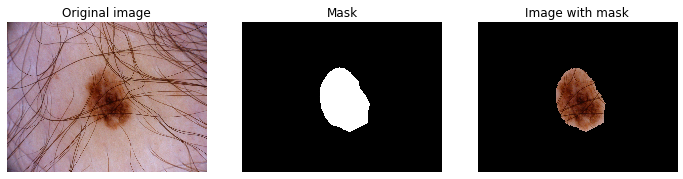

In [0]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

# Choose a figure and plot it with the ground truth segmentation
indexIm=6
filename = listImages[indexIm]
im = imread(filename)
filename_Segmentation = filename[:-4] + '_Segmentation.png'
im_Seg = imread(filename_Segmentation) # Value 0 or 255
im_Seg_bool = (im_Seg/255).astype(np.uint8) # To get uint8
im_Seg_expand = np.expand_dims(im_Seg_bool, axis=2)
im_mul_mask = (im_Seg_expand*im) # pixel-wise product

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(im)
grid[0].axis('off')
grid[0].set_title("Original image")
grid[1].imshow(im_Seg,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Mask")
grid[2].imshow(im_mul_mask)
grid[2].axis('off')
grid[2].set_title("Image with mask")

First, let's simplify the problem by using only the blue channel and rescaling the figure

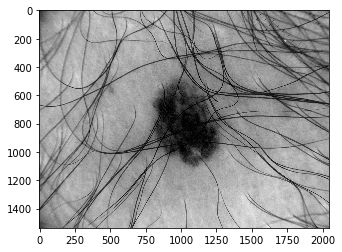

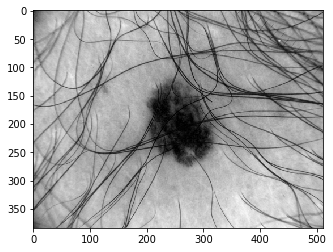

In [0]:
from skimage.transform import rescale
from skimage import img_as_bool

# We only select the blue channel to start
imb=im[:,:,2]
plt.figure()
plt.imshow(imb,cmap='gray')
plt.show()

# We rescale to speed up computations
imbr = np.uint8(rescale(imb, 0.25, anti_aliasing=True)*255)
im_Seg_r =  np.uint8(rescale(im_Seg, 0.25, anti_aliasing=True)*255) 
im_Seg_r_bool = (im_Seg_r/255).astype(np.uint8)

plt.figure()
plt.imshow(imbr,cmap='gray') 
plt.show()

Now, let's try to use K-means to directly segment the image. We will use the scikit-learn implementation.

Text(0.5, 1.0, 'Ground Truth Segmenation')

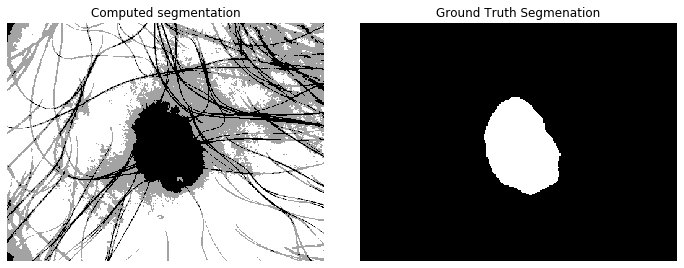

In [0]:
from sklearn.cluster import KMeans

Ncluster=3

x, y = imbr.shape
imFloat = np.array(imbr, dtype=np.float64) / 255 # transform into float for computational reason
kmeans = KMeans(n_clusters=Ncluster, n_jobs=-1) # use K-means algorithm 
kmeans.fit(imFloat.reshape(x*y,1)) # fit to the data reshapds as a 1D vector

cluster_centers = kmeans.cluster_centers_ # estimated centers
cluster_labels = kmeans.labels_ # estimated labels for each pixel

kmeansSeg = cluster_centers[cluster_labels].reshape(x, y) # reshaped as the original image
if Ncluster==2: # make kmeansSeg boolean
  kmeansSeg[kmeansSeg == max(kmeansSeg.flatten())] = 0  
  kmeansSeg[kmeansSeg == max(kmeansSeg.flatten())] = 1

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(kmeansSeg,cmap='gray')
grid[0].axis('off')
grid[0].set_title("Computed segmentation")
grid[1].imshow(im_Seg_r_bool,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Ground Truth Segmenation")

To quantitavely compare the two segmentations, we can use the Dice score defined as $DSC=\frac{2TP}{2TP+FP+FN}$ for boolean data. First, we should check that the computed segmentation mask is coherent with the ground truth

The dice similarity is  0.18262617967962225


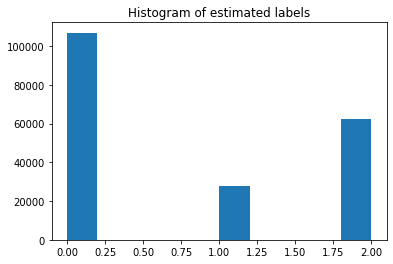

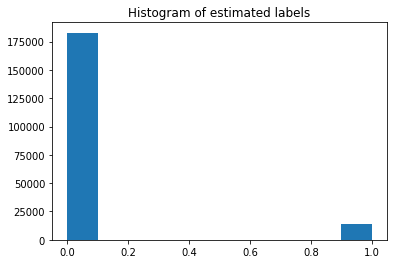

In [0]:
from scipy.spatial.distance import dice

plt.figure()
plt.hist(cluster_labels)
plt.title('Histogram of estimated labels')

plt.figure()
plt.hist(im_Seg_r_bool.flatten())
plt.title('Histogram of estimated labels')

print('The dice similarity is ', 1-dice(cluster_labels,im_Seg_r_bool.flatten()))


Try to change the number of clusters, can you correctly segment the skin lesion ? 

**Getting a higher number of clusters divides the lesion into many areas and does not isolate the hair area.** 

**The issue here is the hair that has an impact on the segmentation as done here for $N_{\text{clusters}} = 2$. We can then try and pre-process the image to remove the hair before segmenting, which would probably improve the result.**

As you can see, there are several hairs within and outside the skin lesion image. One would like to remove and restore the hair regions to effectively segment and analyze the lesions. 

The first goal of this practical session will be to remove the hair. You will use morphological operators, interpolation techniques and filter as seen in the previous lectures. 

# Mathematical Morphology
Here, we will remind you some morphological operators that you could use to remove the hair and segment the lesion. Please note that the structural elements and the hyper-parameters have been randomly chosen... you should probably change them.

In [0]:
import skimage.morphology as morpho  

def strel(forme,taille,angle=45):
    """renvoie un element structurant de forme  
     'diamond'  boule de la norme 1 fermee de rayon taille
     'disk'     boule de la norme 2 fermee de rayon taille
     'square'   carre de cote taille (il vaut mieux utiliser taille=impair)
     'line'     segment de langueur taille et d'orientation angle (entre 0 et 180 en degres)
      (Cette fonction n'est pas standard dans python)
    """

    if forme == 'diamond':
        return morpho.selem.diamond(taille)
    if forme == 'disk':
        return morpho.selem.disk(taille)
    if forme == 'square':
        return morpho.selem.square(taille)
    if forme == 'line':
        angle=int(-np.round(angle))
        angle=angle%180
        angle=np.float32(angle)/180.0*np.pi
        x=int(np.round(np.cos(angle)*taille))
        y=int(np.round(np.sin(angle)*taille))
        if x**2+y**2 == 0:
            if abs(np.cos(angle))>abs(np.sin(angle)):
                x=int(np.sign(np.cos(angle)))
                y=0
            else:
                y=int(np.sign(np.sin(angle)))
                x=0
        rr,cc=morpho.selem.draw.line(0,0,y,x)
        rr=rr-rr.min()
        cc=cc-cc.min()
        img=np.zeros((rr.max()+1,cc.max()+1) )
        img[rr,cc]=1
        return img
    raise RuntimeError('Erreur dans fonction strel: forme incomprise')

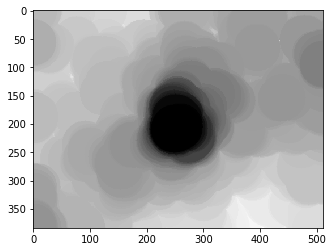

In [0]:
#fermeture par un disque
sizeDisque=40
disk=strel('disk',sizeDisque)
closeDisk=morpho.closing(imbr,disk)
plt.figure()
plt.imshow(closeDisk,cmap='gray')
plt.show()

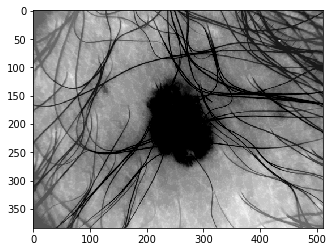

In [0]:
# Reconstruction par erosion
RecEr=np.max(imbr) - morpho.reconstruction(np.max(imbr)-closeDisk,np.max(imbr)-imbr)
plt.figure()
plt.imshow(RecEr,cmap='gray')
plt.show()


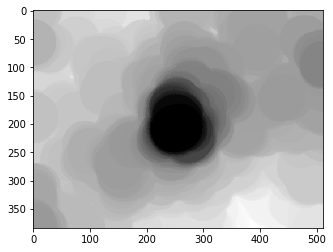

In [0]:
# Overture (remove small bright parts)
N=2
se=strel('disk',N)
Open=morpho.opening(closeDisk,se)
plt.figure()
plt.imshow(Open,cmap='gray')
plt.show()

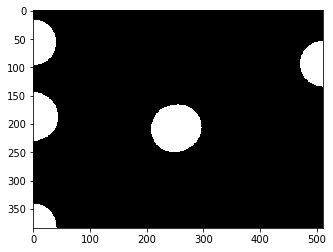

In [0]:
# Minima regionaux
maxIm=255
temp=Open.copy()
    
for i in range(Open.shape[0]):
    for j in range(Open.shape[1]):
        if Open[i,j] < maxIm: 
            temp[i,j]=Open[i,j]+1
reco=maxIm-morpho.reconstruction(maxIm-temp,maxIm-Open)
minReg=np.uint8(reco)-Open
plt.figure()
plt.imshow(minReg,cmap='gray')
plt.show()

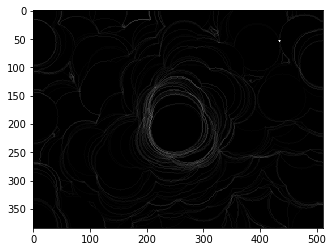

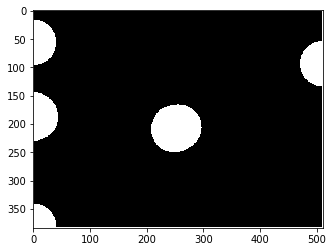

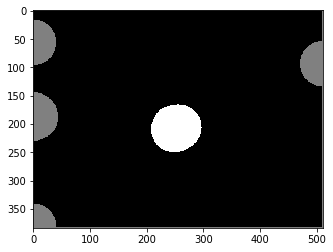

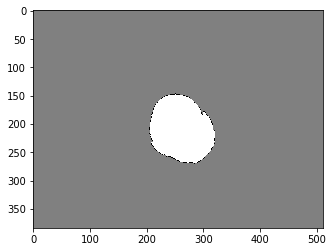

In [0]:
from scipy import ndimage as ndi

#segmentation par ligne de partage des eaux avec marqueurs

#gradient morphologique de l'image initiale
se=morpho.selem.disk(1)
grad=morpho.dilation(closeDisk,se)-morpho.erosion(closeDisk,se)
plt.figure()
plt.imshow(grad,cmap='gray')
plt.show()

#suppression des marqueurs trop petits
tailleMin=5
seM=strel('disk',tailleMin)
minReg=morpho.opening(minReg,seM)

#ajout d'un marqueur sur le bord de l'image
for i in range(minReg.shape[0]):
    minReg[i,0]=1
    minReg[i,minReg.shape[1]-1]=1
for j in range(minReg.shape[1]):
    minReg[0,j]=1
    minReg[minReg.shape[0]-1,j]=1
    
plt.figure()
plt.imshow(minReg,cmap='gray')
plt.show()

markers = ndi.label(minReg)[0]
plt.figure()
plt.imshow(markers,cmap='gray')
plt.show()

labels = morpho.watershed(grad, markers,watershed_line=True)
plt.figure()
plt.imshow(labels,cmap='gray')
plt.show()

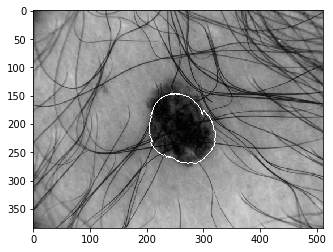

The dice similarity is  0.8755396269446933


In [0]:
#%% Visualiation du resultat

segm=labels.copy()
for i in range(segm.shape[0]):
    for j in range(segm.shape[1]):
        if segm[i,j] == 0: 
            segm[i,j]=255
        else:
            segm[i,j]=0
segm=ndi.binary_fill_holes(segm).astype(int)
#NB: ce resultat peut servir d'initialisation pour une autre methode de segmentation (croissance de regions, segmentation markovienne, etc.)

#superposition des contours de la segmentation a l'image initiale
contour=morpho.dilation(segm,se)-morpho.erosion(segm,se)
contourSup=np.maximum(contour*255,imbr)
plt.figure()
plt.imshow(contourSup,cmap='gray')
plt.show()       

print('The dice similarity is ', 1-dice(segm.flatten(),im_Seg_r_bool.flatten()))



**Question**: Using the previous methods (and other if you wish), propose a pipeline to correctly segment the lesions of at least two different images. 

**I chose to use a pipeline based on the morphological operations described above.**


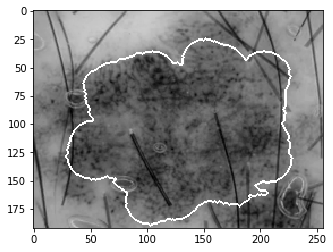

The dice similarity is  0.7494943381802546


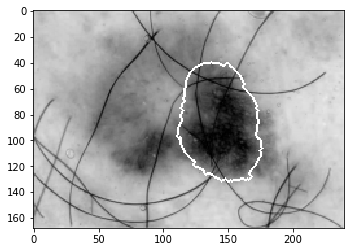

The dice similarity is  0.48259731580999055


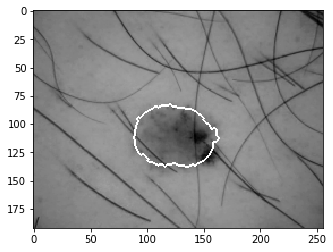

The dice similarity is  0.7983797203710963


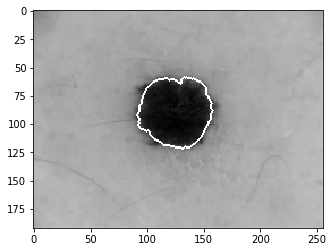

The dice similarity is  0.9453227931488801


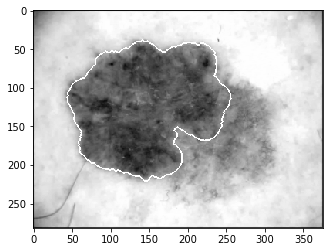

The dice similarity is  0.821721626356065


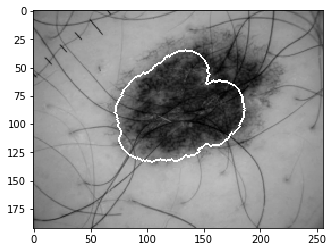

The dice similarity is  0.6718103448275863


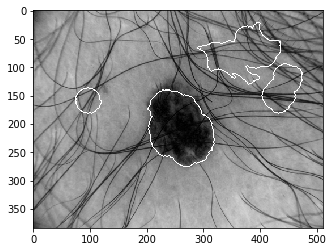

The dice similarity is  0.5910119292472233


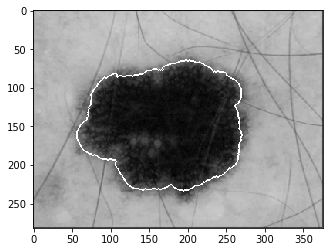

The dice similarity is  0.9072944783231697


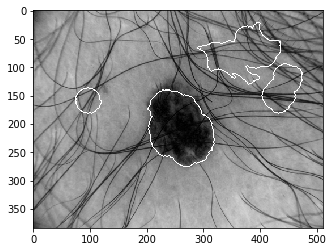

The dice similarity is  0.585349802571631


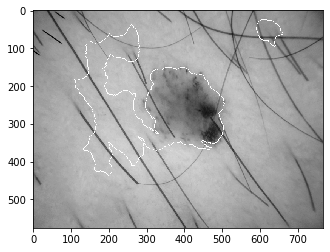

The dice similarity is  0.57418272561113


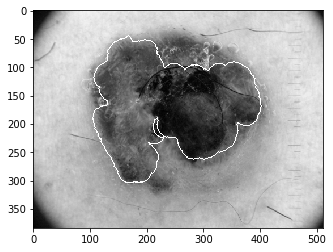

The dice similarity is  0.7977141504569163


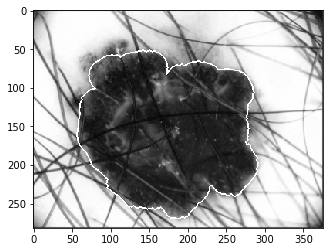

The dice similarity is  0.9424197976606867


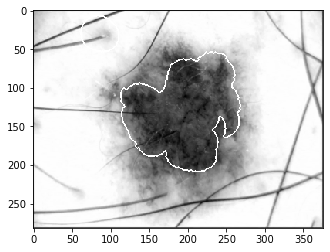

The dice similarity is  0.6148569226322382


In [0]:
import skimage.morphology as morpho  
from scipy import ndimage as ndi

def contrast_streching(im): # to rescale the grey levels between 0 and 255
  return (255/(np.max(im)-np.min(im)))*(im - np.min(im))

def pipelineSegmenting(indexIm, sizeDisque = 20):
  
  #%% Image definition
  filename = listImages[indexIm]
  im = imread(filename)
  imb=im[:,:,2]
  filename_Segmentation = filename[:-4] + '_Segmentation.png'
  imbr = np.uint8(rescale(imb, 0.25, anti_aliasing=True)*255)
  
  im_Seg = imread(filename_Segmentation) # Value 0 or 255
  im_Seg_bool = (im_Seg/255).astype(np.uint8) # To get uint8
  im_Seg_r =  np.uint8(rescale(im_Seg, 0.25, anti_aliasing=True)*255) 
  im_Seg_r_bool = (contrast_streching(im_Seg_r)/255).astype(np.uint8)

  #%% Fermeture par un disque
  disk=strel('disk',sizeDisque)
  closeDisk=morpho.closing(imbr,disk)
  
  #%% Ouverture (remove small bright parts)
  se=strel('disk',2)
  Open=morpho.opening(closeDisk,se)

  #%% Minima regionaux
  maxIm=255
  temp=Open.copy()
      
  for i in range(Open.shape[0]):
      for j in range(Open.shape[1]):
          if Open[i,j] < maxIm: 
              temp[i,j]=Open[i,j]+1

  reco=maxIm-morpho.reconstruction(maxIm-temp,maxIm-Open)
  minReg=np.uint8(reco)-Open

  #%% Segmentation par ligne de partage des eaux avec marqueurs

  #gradient morphologique de l'image initiale
  se=morpho.selem.disk(1)
  grad=morpho.dilation(closeDisk,se)-morpho.erosion(closeDisk,se)
  
  #suppression des marqueurs trop petits
  tailleMin=5
  seM=strel('disk',tailleMin)
  minReg=morpho.opening(minReg,seM)

  #ajout d'un marqueur sur le bord de l'image
  for i in range(minReg.shape[0]):
      minReg[i,0]=1
      minReg[i,minReg.shape[1]-1]=1
  for j in range(minReg.shape[1]):
      minReg[0,j]=1
      minReg[minReg.shape[0]-1,j]=1

  markers = ndi.label(minReg)[0]
  labels = morpho.watershed(grad, markers,watershed_line=True)
  
  #%% visualiation du resultat

  segm=labels.copy()
  for i in range(segm.shape[0]):
      for j in range(segm.shape[1]):
          if segm[i,j] == 0: 
              segm[i,j]=255
          else:
              segm[i,j]=0
  segm=ndi.binary_fill_holes(segm).astype(int)
  
  #superposition des contours de la segmentation a l'image initiale
  contour=morpho.dilation(segm,se)-morpho.erosion(segm,se)
  contourSup=np.maximum(contour*255,imbr)
  plt.figure()
  plt.imshow(contourSup,cmap='gray')
  plt.show()     

  print('The dice similarity is ', 1-dice(segm.flatten(),im_Seg_r_bool.flatten()))

#%% Testing the pipeline
for k in range(len(listImages)):
  pipelineSegmenting(k)  

**The pipeline works already rather fine on some lesions, with Dice score**:
* **above 0.90 for 3 out of 13 images** 
* **above 0.70 for 7 out of 13 images**

**Yet, it is not working on all of the lesions, especially for some hairy images or for lesions that have a colour gradation.**

**On top of that, it could be added that the size of the structuring element has an impact on the dice score for each image, so it should be <u>adapted for each image</u>. However, to get some automation of the process, I chose to set it at 20 and run the loop. But this is certainly an axis for improvement: automatically finding the best size for structuring element.**

## DullRazor


One of the simplest algorithms for Hair Removal is DullRazor proposed by Lee et al. It consists of three steps: (1) identification of the hair using morphological closing operation; (2) replacement of the hair pixels with normal (close) skin pixels using bilinear interpolation; and (3) smoothing the final result with a median filter.

---

*T.K. Lee, V. Ng, R. Gallagher, A. Coldman, D. McLean, A Dullrazor, Software approach to hair removal from images, J. Comput. Biol. Med. 27 (1997) 533–543*


Once computed a mask identifying the hair, we need to replace the hair pixels with close skin pixels. We could use an interpolation scheme using, for instance, scipy.interpolate or np.interp. Or a more advanced solution based on inpaiting (recommended, you will see it in IMA206) such as: 

In [0]:
from skimage.restoration import inpaint
#image_result = inpaint.inpaint_biharmonic(imbr, mask, multichannel=False)

Eventually, authors suggest to use a median filter to smooth the results. 

Text(0.5, 1.0, 'image filtered')

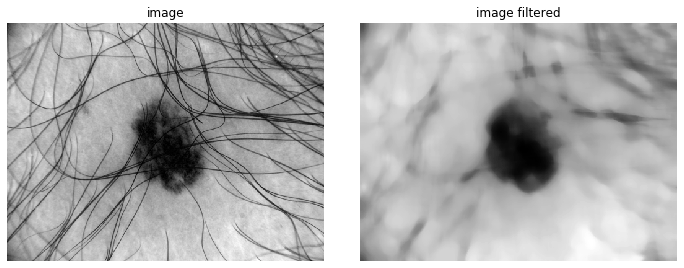

In [0]:
from scipy import ndimage

medianFilt = ndimage.median_filter(imbr, size=20)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(medianFilt,cmap='gray')
grid[1].axis('off')
grid[1].set_title("image filtered")


**Question**: Implement the original (or a modified version) of the DullRazor algorithm. If you modify the algorithm, please explain why. 

**I slighlty modified the code at the second step: using biharmonic inpainting instead of bilinear interpolation, which gives better results empirically.**


In [0]:
def dullRazor(imbr):

  #%% 1 - Identification of the hair using morphological closing operation

  # Closing using a square
  sizeSquare=5
  square=strel('square',sizeSquare)
  closeSquare = morpho.closing(imbr, square)
  thin = closeSquare - imbr #thin elements (the hair)

  # Mask of the hair
  mask = np.zeros_like(thin) 
  mask[thin > 15] = 1

  #%% 2 - Replacement of the hair pixels with normal (close) skin pixels using inpainting
  image_result = inpaint.inpaint_biharmonic(imbr, mask, multichannel=False)

  #%% 3 - Smoothing the final result with a median filter
  medianFilt = ndi.median_filter(image_result, size=20)*255

  return medianFilt

Text(0.5, 1.0, 'image after Dull Razor')

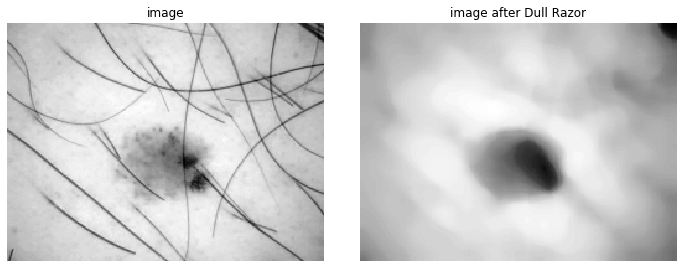

In [0]:
indexIm = 2
filename = listImages[indexIm]
im = imread(filename)
imb = im[:,:,2]
imbr = np.uint8(rescale(imb, 0.25, anti_aliasing=True)*255)
medianFilt = dullRazor(imbr)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                  nrows_ncols = (1, 2),
                  axes_pad = 0.5)

grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(medianFilt,cmap='gray')
grid[1].axis('off')
grid[1].set_title("image after Dull Razor")

**We hence can use this algorithm to remove the hair and help further segmenting algorithm to work properly.**

## Otsu's algorithm

Otsu's method looks for a threshold to split a gray-level image into two separate regions, based on their grey-level values. Since the maximum number of grey-levels is finite (and small, 256), we can use an exhaustive search.

The grey-level threshold is the one that minimises the intra-class intensity variance, defined as a weighted sum of the variances of the two regions :

$argmin_{\tau}  \omega_0(\tau)\sigma_0^2(\tau) + \omega_1(\tau)\sigma_1^2(t)$

where

- $\sigma_0^2(\tau)$ and $\sigma_1^2(\tau)$ are the intensity variances of the pixels in the first and second regions
- $\omega_0(\tau)$ and $\omega_1(\tau)$ are the weights of the first and second regions 

Given the histogram of the image with $L$ bins where each bin $i$ has $p(i)$ pixels, we define the weights $\omega_0(\tau)$ and $\omega_1(\tau)$ as:

- $\omega_0(\tau) = \sum_{i=0}^{\tau -1} p(i)$
- $\omega_1(\tau) = \sum_{i = \tau}^{L-1} p(i)$


**Question**: Implement this algorithm in a function called ``segmentation_otsu``. Note : only analyse thresholds which produce two distinct regions. Furthemore, remember that the image has only 256 discrete values. Choose the threshold values accordingly.

Text(0.5, 1.0, 'Otsu')

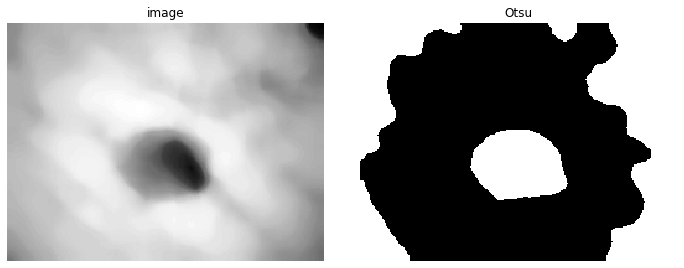

In [0]:
def segmentation_otsu(img):

    min_sigma = np.float('inf')
    tau_out = 0
    min_level = 0.0
    max_level = 255.0
    n_levels = 256
    
    for tau in np.linspace(min_level, max_level,n_levels):
        # first, get the weights of the two regions
        omega_0 = np.sum(img<tau)
        omega_1 = np.sum(img>=tau)
        
        # only analyse thresholds which give two distinct regions
        if omega_0 != 0 and omega_1 != 0:
            sigma_0 = np.std(img[img<tau])
            sigma_1 = np.std(img[img>=tau])
            sigma_total_square = omega_0*sigma_0**2 + omega_1*sigma_1**2
            sigma_total = np.sqrt(sigma_total_square)

            if (sigma_total < min_sigma):
                tau_out = tau
                min_sigma = sigma_total

    img_out = np.zeros((img.shape[0],img.shape[1]))
    img_out[img<tau_out] = 1
    return img_out,tau_out

img_out, __ = segmentation_otsu(medianFilt)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(medianFilt, cmap = 'gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(img_out,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Otsu")

**The result given here seems good but we observe that the edges of the image are also 'segmented', which is not something we wish to have. This is due to the fact that Otsu does not take any neighbouring notion whatsoever into account.** 

You can apply the Otsu method to segment previously pre-processed images.

The best threshold is 124.0
The dice similarity is  0.9275158339197748


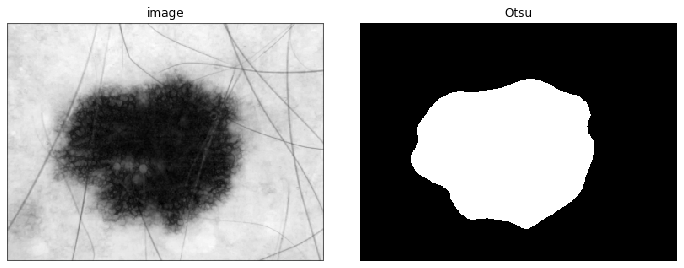

In [0]:
def contrast_streching(im): # to rescale the grey levels between 0 and 255 
  return (255/(np.max(im)-np.min(im)))*(im - np.min(im))

indexIm = 7
filename = listImages[indexIm]
im = imread(filename)
imb = im[:,:,2]
imbr = np.uint8(rescale(imb, 0.25, anti_aliasing=True)*255)
filename_Segmentation = filename[:-4] + '_Segmentation.png'
im_Seg = imread(filename_Segmentation) # Value 0 or 255
im_Seg_r =  np.uint8(rescale(im_Seg, 0.25, anti_aliasing=True)*255) 
im_Seg_r_bool = (contrast_streching(im_Seg_r)/255).astype(np.uint8)

medianFilt = dullRazor(imbr)
Otsu,tau_otsu = segmentation_otsu(medianFilt)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 2),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(Otsu,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Otsu")

print('The best threshold is {}'.format(tau_otsu))
print('The dice similarity is ', 1-dice(Otsu.flatten(),im_Seg_r_bool.flatten()))


One of the problem of the Otsu method it's that there is no notion of connectivity (two regions far away can be in the same region). For such a notion, we turn to region merging.

## Region merging

The region merging algorithm is quite simple : we start with a small region, and add pixels progressively to the region, according to a criterion. We choose the following criterion :

- A pixel $p$ is added to the region if the absolute difference between the pixel value and the region's average value is less than a threshold value (which you must set).

First, we can create a function called ``initialize_segmentation`` which initialises the segmentation with a small circular region centred on a given seed point (the seed point is an input). For this, the following function :

- scipy.ndimage.morphology.distance_transform_edt

can be useful.

In [0]:
from scipy.ndimage.morphology import distance_transform_edt

def initialize_segmentation(seed_pt,img_shape):
    seg_init = np.zeros(img_shape).astype(float)
    seg_init[ seed_pt[0], seed_pt[1]] = 1
    dist = distance_transform_edt(np.abs(1-seg_init))

    # initialise the seeded region with a certain radius
    size_radius = 5
    seg_init = dist < size_radius
    return seg_init

Now, we can create a function called ``segmentation_region_growing`` which carries out the region growing algorithm, with the criterion above, and which uses the ``initialize_segmentation`` function. Again, the functions from ``scipy.ndimage.morphology`` can be useful here.

In [0]:
from scipy.ndimage import binary_dilation

def segmentation_region_growing(img,seed_pt,tau):

    # define the neighbourhood (for instance 4-connected pixels)
    nbhood = np.asarray( [ [0,1,0],[1,1,1],[0,1,0]] )

    seg_init = initialize_segmentation(seed_pt,img.shape)
    seg_n_plus_1 = seg_init
    seg_n = np.zeros(seg_n_plus_1.shape)

    # loop while the region can still keep growing
    while( np.abs(seg_n_plus_1 != seg_n).sum() != 0):
        seg_n = seg_n_plus_1
        seg_n_plus_1 = binary_dilation(seg_n, structure=nbhood).astype(seg_n.dtype)
        # calculate average value
        avg = np.sum( img[seg_n>0] ) / ( float(seg_n.sum()))
        seg_n_plus_1 = np.logical_and( seg_n_plus_1 , np.abs(img - avg) < tau - avg)
        # do not lose previous points of the segmentation
        seg_n_plus_1 = np.logical_or( seg_n_plus_1 , seg_n)

    return seg_n,seg_init

**Question**: Carry out the segmentation on the previously pre-processed images with the seed point and threshold specified in the following code. The proposed implementation is very simple. We could definitely improve it. Do you see how ? You can simply explain how you would do it or, if you have time, even try to implement it. 

The dice similarity is  0.9275158339197748


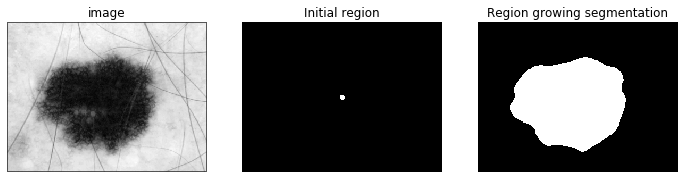

In [0]:
indexIm = 7
filename = listImages[indexIm]
im = imread(filename)
imb = im[:,:,2]
imbr = np.uint8(rescale(imb, 0.25, anti_aliasing=True)*255)
filename_Segmentation = filename[:-4] + '_Segmentation.png'
im_Seg = imread(filename_Segmentation) # Value 0 or 255
im_Seg_r =  np.uint8(rescale(im_Seg, 0.25, anti_aliasing=True)*255) 
im_Seg_r_bool = (contrast_streching(im_Seg_r)/255).astype(np.uint8)

medianFilt = dullRazor(imbr)
__,tau_otsu = segmentation_otsu(medianFilt)

a, b = medianFilt.shape
seed_pt = np.asarray([a//2, b//2]) # initial point that belongs to the skin lesion in practice
tau = tau_otsu # threshold, same as otsu's

img_out_region_growing,seg_init = segmentation_region_growing(medianFilt,seed_pt,tau)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(seg_init,cmap='gray')
grid[1].axis('off')
grid[1].set_title("Initial region")
grid[2].imshow(img_out_region_growing,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Region growing segmentation")

print('The dice similarity is ', 1-dice(img_out_region_growing.flatten(),im_Seg_r_bool.flatten()))


**This method works but one needs to know a seed point belonging to the skin lesion and an appropriate threshold prior to lauching the algorithm. This was done empirically for the above example (using the threshold value given by Otsu).**

**This method could then be enhanced by automating the process of seed point detection and threshold calculus.**

# Graph-Cut
You can also use graph-cut, as seen in the previous lecture, to segment the image or to remove hair. You could, for instance, see the hair as noise and try to remove it using the gaussian model or the one of Potts.

Here, you can find an example of binary segmentation.

**Question**: propose a pipeline, based on graph-cuts and other pre-processing or post-processing methods, to correctly segment the images.

In [0]:
!pip install PyMaxflow
import maxflow

The dice similarity is  0.9263913235800062


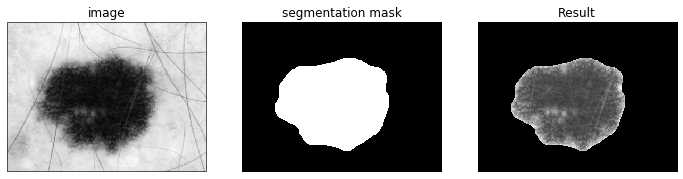

In [0]:
## Graph cut binaire
def graphCut(Otsu, medianFilt):
  beta = 5000
  m1 = np.mean(medianFilt[Otsu == 0])
  m2 = np.mean(medianFilt[Otsu == 1])


  g = maxflow.Graph[float]()
  nodeids = g.add_grid_nodes(medianFilt.shape)
  g.add_grid_edges(nodeids, beta)
  g.add_grid_tedges(nodeids, (medianFilt-m1)**2, (m2-medianFilt)**2)
  flow = g.maxflow()
  sgm = g.get_grid_segments(nodeids)
  im_bin = np.int_(np.logical_not(sgm))
  
  return im_bin

im_bin = graphCut(Otsu, medianFilt)

fig = plt.figure(figsize=(12, 12))
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5)
grid[0].imshow(imbr,cmap='gray')
grid[0].axis('off')
grid[0].set_title("image")
grid[1].imshow(im_bin,cmap='gray')
grid[1].axis('off')
grid[1].set_title("segmentation mask")
grid[2].imshow(imbr*im_bin,cmap='gray')
grid[2].axis('off')
grid[2].set_title("Result")

print('The dice similarity is ', 1-dice(im_bin.flatten(),im_Seg_r_bool.flatten()))


**I found that I needed a high regularisation for the graph-cut method to work fine, so I set the $\beta = 5000$ which gave me rather good results in the following.**

**We then implement the final pipeline to segment a skin lesion:**
* **The first step is pre-processing: using Dull Razor to remove the hair**
* **The second step is Otsu's segmenting method to actually get the contours**
* **The third step is post-processing which aims at solving the problems we mentioned earlier with Otsu, i.e. adding a neighbouring notion**

**The third step is implemented by keeping the largest non null connected component which is closest to the center of the mask, and removing all of the others. In practice, this post-processing algorithm turns the white part of the mask in the edges (as we saw in the Otsu example above) into black, so that we only have the skin lesion.**

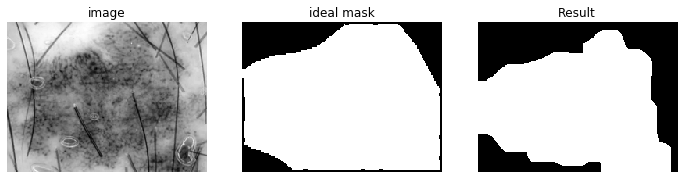

The dice similarity is  0.8808284307501305


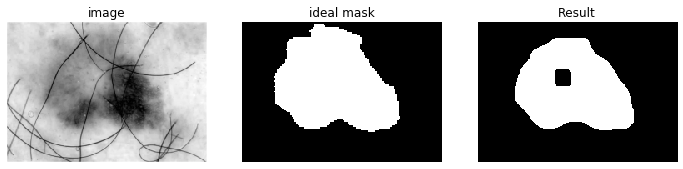

The dice similarity is  0.9018614561974833


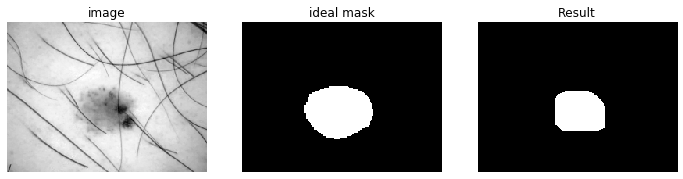

The dice similarity is  0.7863988446895103


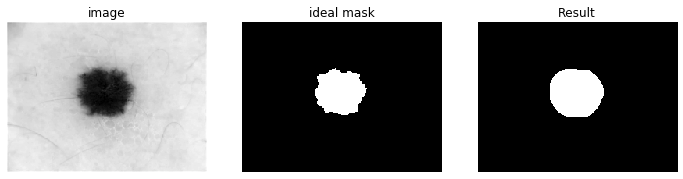

The dice similarity is  0.9126576366184026


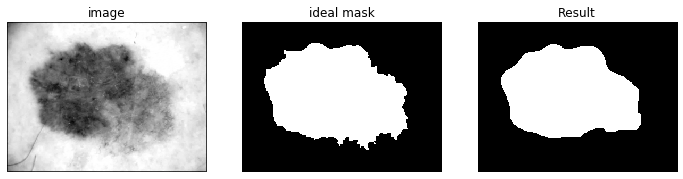

The dice similarity is  0.9539147196740809


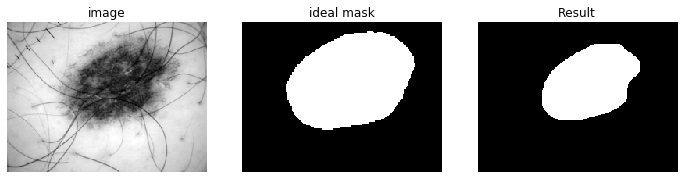

The dice similarity is  0.7355765285186705


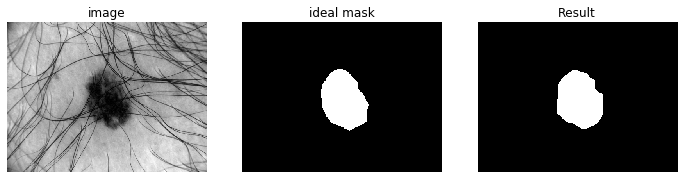

The dice similarity is  0.9515534299587456


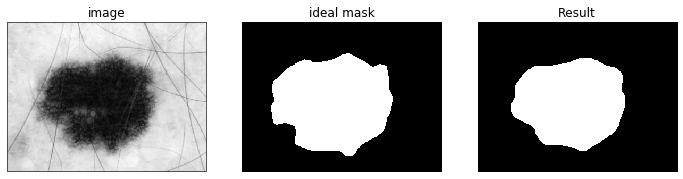

The dice similarity is  0.9263913235800062


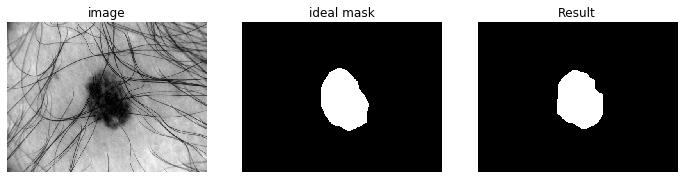

The dice similarity is  0.9486126486447881


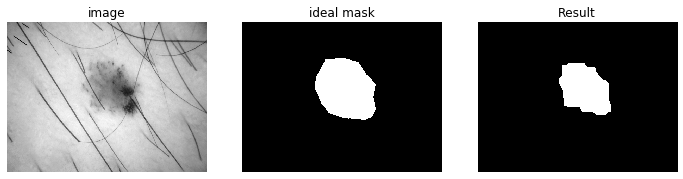

The dice similarity is  0.8164619434086422


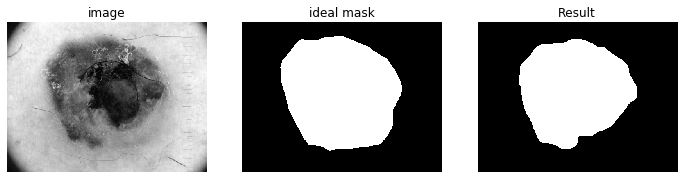

The dice similarity is  0.925134621356135


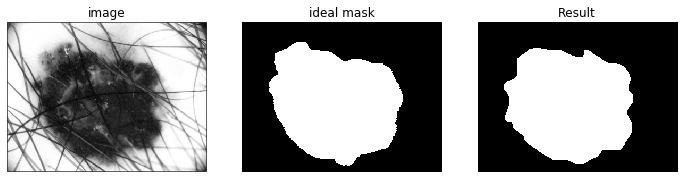

The dice similarity is  0.9533791898678895


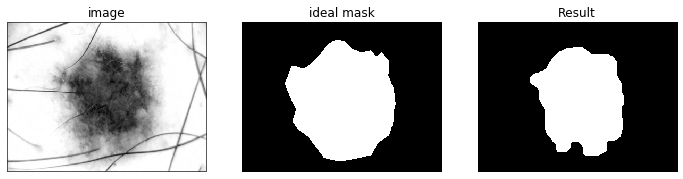

The dice similarity is  0.8695724147064179


In [0]:
#%% First functions

import skimage

def contrast_streching(im): # to rescale the grey levels between 0 and 255
  return (255/(np.max(im)-np.min(im)))*(im - np.min(im))

def post_processing(mask):
  # Keeping the connected component which is closest to the center
  x, y = mask.shape
  center_x = x/2
  center_y = y/2

  labelmask = skimage.measure.label(mask)
  __, count = np.unique(labelmask, return_counts=True)

  distance_to_center = []
  for i in range(len(count)):
    connectedComponent = (labelmask == i)
    centroid = ndimage.measurements.center_of_mass(connectedComponent)

    distance = (centroid[0]-center_x)**2 + (centroid[1]-center_y)**2
    distance_to_center.append(distance)
  distancer_to_center = np.array(distance_to_center)

  while np.median(mask[labelmask == np.argmin(distance_to_center)]) == 0 :
    distance_to_center[np.argmin(distance_to_center)] = x**2+y**2 #the distance can't be higher than the dimension of the image

  oneComponentMask = (labelmask == np.argmin(distance_to_center))
  return oneComponentMask

def imagePrepare(indexIm):
  
  filename = listImages[indexIm]
  
  im = imread(filename)
  imb=im[:,:,2]
  imbr = np.uint8(rescale(imb, 0.25, anti_aliasing=True)*255)
  
  filename_Segmentation = filename[:-4] + '_Segmentation.png'
  im_Seg = imread(filename_Segmentation) # Value 0 or 255
  im_Seg_bool = (im_Seg/255).astype(np.uint8) # To get uint8
  im_Seg_r =  np.uint8(rescale(im_Seg, 0.25, anti_aliasing=True)*255) 
  im_Seg_r_bool = (contrast_streching(im_Seg_r)/255).astype(np.uint8)
  
  return imbr, im_Seg_r_bool

####################################################################################################################################################
#%% Pipeline

def pipelineFinale(indexIm):
  
  ## 1 - Preparing the data
  imbr, im_Seg_r_bool = imagePrepare(indexIm)

  ## 2 - Pre-processing: hair removal with Dull Razor
  medianFilt = dullRazor(imbr)

  ## 3 - Segmentation using Otsu
  Otsu,tau = segmentation_otsu(medianFilt) 
  im_bin = graphCut(Otsu, medianFilt)

  ## 4 - Post-processing to add a notion of connectivity
  im_bin = post_processing(im_bin)

  return imbr, im_Seg_r_bool, im_bin


#%% Testing the pipeline on the set

for k in range(len(listImages)):
  fig = plt.figure(figsize=(12, 12))
  grid = AxesGrid(fig, 111,
                  nrows_ncols = (1, 3),
                  axes_pad = 0.5)
  
  a, b, c = pipelineFinale(k)
  grid[0].imshow(a,cmap='gray')
  grid[0].axis('off')
  grid[0].set_title("image")
  grid[1].imshow(b,cmap='gray')
  grid[1].axis('off')
  grid[1].set_title("ideal mask")
  grid[2].imshow(c,cmap='gray')
  grid[2].axis('off')
  grid[2].set_title("Result")
  plt.show()
  print('The dice similarity is ', 1-dice(c.flatten(),b.flatten()))
  

**We observe that <u>all the Dice scores are now above 0.7</u>, and that 8 out of 13 images are even above 0.90. We can conclude that we have found an effective way to segment the skin lesions, thanks to the 3 steps described.**